In [1]:
## Importar as bibliotecas
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
import pandas_ta as ta

In [2]:
## Importar os dados
backtest = pd.read_excel("C:/Users/lucas/OneDrive/Área de Trabalho/Scalping/teste.xlsx")
db = pd.read_excel("C:/Users/lucas/OneDrive/Área de Trabalho/Scalping/WIN_M5.xlsx")

In [3]:
## Deletando colunas inutilizadas
backtest.pop('Tipo')
backtest.pop('Volume')
backtest.pop('Ordem')
backtest.pop('Oferta')
backtest.pop('Comissão')
backtest.pop('Swap')
backtest.pop('Saldo')

db.pop('<SPREAD>')

0         5
1         5
2         5
3         5
4         5
         ..
100316    5
100317    5
100318    5
100319    5
100320    0
Name: <SPREAD>, Length: 100321, dtype: int64

In [4]:
## Tratando o nome das colunas do backtest
new_backtest_column_names = { 'Horário': 'datetime', 'Preço': 'price', 'Lucro': 'profit', 'Comentário': 'comment' }
backtest = backtest.rename(columns = new_backtest_column_names)

In [5]:
##  Tratando o horário da base de dados
db['datetime'] = db['<DATE>'].map(str) + ' ' + db['<TIME>'].map(str)
db.pop('<DATE>')
db.pop('<TIME>')

## Tratando o horário do backtest
rounded_data = []
for data in backtest['datetime']:
    # Separar o hórario
    time = data[-8:]

    # Separar as horas, minutos e segundos
    hours = int(time[:2])
    minutes = int(time[3:-3])
    seconds = int(time[-2:])

    round_minutes = (minutes + 5 - (minutes % 5)) % 60

    # Verifica se é necessário adicionar uma unidade na casa das horas
    if minutes > round_minutes and round_minutes == 0:
        hours += 1

    # Correção de síntax
    if round_minutes == 0:
        round_minutes = '00'
    else:
        round_minutes  = str(round_minutes)

    # Adiciona no array 
    rounded_data.append(data[:10] + ' ' + str(hours) + ':' + round_minutes + ':00')

backtest['datetime'] = rounded_data

In [6]:
## Tratando o nome das colunas da base de dados
new_db_column_names = { '<OPEN>': 'open', '<HIGH>': 'high', '<LOW>': 'low', '<CLOSE>': 'close', '<TICKVOL>': 'tickvol', '<VOL>': 'volume' }
db = db.rename(columns=new_db_column_names)

In [149]:
db['rsi'] = ta.rsi(db['close'])
db['cdl_doji'] = ta.cdl_doji(db['open'], db['high'], db['low'], db['close'])
db.head()

,open,high,low,close,tickvol,volume,datetime,rsi,cdl_doji
0,116935,116940,116740,116890,22974,99157,2020.01.15 16:25:00,NaN,0
1,116890,117040,116870,117035,20474,86836,2020.01.15 16:30:00,NaN,0
2,117025,117115,116970,116995,21703,95300,2020.01.15 16:35:00,NaN,0
3,117000,117030,116915,116930,13814,60760,2020.01.15 16:40:00,NaN,0
4,116925,116955,116880,116915,10355,45134,2020.01.15 16:45:00,NaN,0


In [96]:
variables = []

# Gambiarra

In [97]:
for db_index, line in db.iterrows():

    # Verifica se o horário desse tick corresponde ao horário de algum trade realizado
    if backtest[backtest['datetime'] == line['datetime']].shape[0] != 0:

        # Verifica se essa transação é uma abertura de posição
        if backtest[backtest['datetime'] == line['datetime']]['comment'].to_list()[0] == '[1] BUY_STOP':

            # Registra o índice da linha
            backtest_index = backtest[backtest['datetime'] == line['datetime']].index[0]

            # Registro se o trade foi ganhador
            comment = backtest[backtest.index == backtest_index + 1]['comment'].to_list()[0]

            result = 0
            
            if comment[:2] == 'sl':
                result = -1
            elif comment[:2] == 'tp':
                result = 1

            # Registra o volume dos candles anteriores
            volume_d_1 = db[db.index == db_index - 1]['volume'].to_list()[0]
            volume_d_2 = db[db.index == db_index - 2]['volume'].to_list()[0]
            volume_d_3 = db[db.index == db_index - 3]['volume'].to_list()[0]

            # Registro da variação desses volumes
            volume_var_1 = ((volume_d_1 / volume_d_2) - 1) * 100
            volume_var_2 = ((volume_d_2 / volume_d_3) - 1) * 100

            # Registro da variação dos candles anteriores
            var_t_1 = ((db[db.index == db_index - 1]['close'].to_list()[0] / db[db.index == db_index - 1]['open'].to_list()[0]) - 1) * 100
            var_t_2 = ((db[db.index == db_index - 2]['close'].to_list()[0] / db[db.index == db_index - 2]['open'].to_list()[0]) - 1) * 100
            var_t_3 = ((db[db.index == db_index - 3]['close'].to_list()[0] / db[db.index == db_index - 3]['open'].to_list()[0]) - 1) * 100

            rsi_t_1 = db[db.index == db_index - 3]['rsi'].to_list()[0]
            rsi_t_2 = db[db.index == db_index - 3]['rsi'].to_list()[0] 

            doji_t_1 = db[db.index == db_index - 3]['cdl_doji'].to_list()[0]
            doji_t_2 = db[db.index == db_index - 3]['cdl_doji'].to_list()[0] 

            variables.append({ 
                'Result': result, 
                'Var. Volume t-1': volume_var_1,
                'Var. Volume t-2': volume_var_2,
                'Var. t-1': var_t_1,
                'Var. t-2': var_t_2,
                'Var. t-3': var_t_3,
                'Doji t-1': doji_t_1,
                'Doji t-2': doji_t_2,
                'RSI t-1': rsi_t_1,
                'RSI t-2': rsi_t_2,
            })


-1
-1
-1
-1
-1
0
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
0
0
1
-1
-1
1
-1
0
1
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
0
1
-1
-1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
0
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
0
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
1
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
1
-1
-1
-1
-1
-1
-1
1
0
0
-1
-1
-1
0
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
0
1
-1
-1
-1
1
-1
-1
-1
-1
0
-1
1
-1
-1
-1
-1
0
0
0
-1
-1
1
0
-1
-1
1
-1
-1
-1
-1
-1
1
-1
1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
1
1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
0
-1
1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
1

In [99]:
df_variables = pd.DataFrame(variables)
df_variables.head(n=50)

,Result,Var. Volume t-1,Var. Volume t-2,Var. t-1,Var. t-2,Var. t-3,Doji t-1,Doji t-2,RSI t-1,RSI t-2
0,-1,62.410004,217.106687,0.114460,0.127340,0.012736,0,0,82.725080,82.725080
1,-1,123.855634,10.935694,0.131178,0.071988,0.021177,0,0,76.460908,76.460908
2,-1,9.288314,-1.205967,0.050695,0.109955,0.042307,0,0,65.063472,65.063472
3,-1,21.572851,38.736433,0.054730,0.215181,-0.042175,0,0,54.345495,54.345495
4,-1,121.394255,-57.140375,0.016831,-0.016829,0.075786,0,0,62.736936,62.736936
5,0,195.692987,-23.499155,0.335937,0.037806,0.067255,0,0,73.846890,73.846890
6,-1,21.379686,34.227231,0.145835,0.012870,-0.072880,0,0,71.883362,71.883362
7,-1,93.497627,-53.275411,0.085016,-0.004251,0.123420,0,0,83.262507,83.262507
8,1,253.308433,-59.722509,0.359051,0.012825,0.089859,0,0,63.949765,63.949765
9,-1,20.536014,26.229040,0.101725,0.152821,0.042470,0,0,80.580108,80.580108


In [130]:

X = df_variables.iloc[:, 1:]
y = df_variables['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [132]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Result   R-squared (uncentered):                   0.546
Model:                            OLS   Adj. R-squared (uncentered):              0.540
Method:                 Least Squares   F-statistic:                              102.9
Date:                Wed, 04 Oct 2023   Prob (F-statistic):                    1.74e-98
Time:                        23:06:58   Log-Likelihood:                         -600.65
No. Observations:                 607   AIC:                                      1215.
Df Residuals:                     600   BIC:                                      1246.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

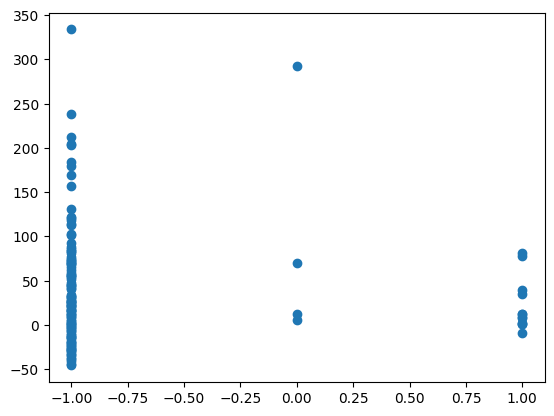

In [148]:
plt.scatter(y_test, X_test['Var. Volume t-1'])
plt.show() 